In [101]:
#Importing packages
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from astropy.time import Time
import json
import bmxobs

class color:
   RED = '\033[91m'
   BOLD = '\033[1m'

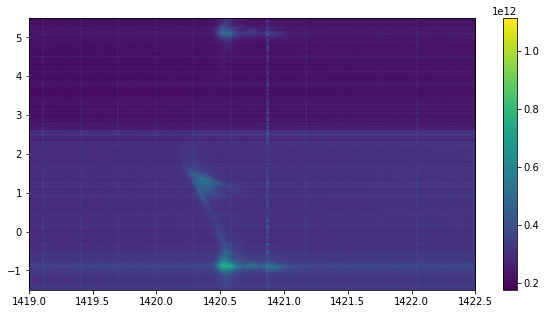

In [102]:
#Load one day's worth of data
#Create waterfall plots showing frequency of signal vs. RA
date = "200514_0700"
d = bmxobs.BMXObs(date, "all_auto")
fig, ax1 = plt.subplots(figsize=(10,5))
pos = ax1.imshow(d[111], aspect="auto", extent=[1419, 1422.5, -1.5, 5.5], origin="lower")
fig.colorbar(pos, ax=ax1)

In [103]:
#Coverte timestamps of signal to mjd
#Reshape signal amplitude and date to smaller array
sig_date = d.mjd
sig = np.mean(d[111], 1)

sig = sig [ :len(sig)//128 * 128]
sig = sig.reshape((-1,128)).mean(axis=1)

sig_date = sig_date [ :len(sig_date)//128 * 128]
sig_date = sig_date.reshape((-1,128)).mean(axis=1)

#Build Time object for sig date
dt = Time(sig_date, format="mjd")

In [104]:
#Requeste fan state data from grafana database for specified time range (local time) 
import requests
from requests.exceptions import HTTPError

url = 'https://www.phy.bnl.gov/bmx_gr_api/query.php'
params_fan = {'data': 'fan', 'sdt': dt.iso[0], 'edt': dt.iso[-1]}
for params in [params_fan]:
    try:
        fan_resp=requests.get(url, params_fan)
        fan_resp.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        print('Success')
        try:
            print(fan_resp.json())
        except:
            print("Error parsing response")

Success
[{'fanstate': '1', 'fsdate': '2020-05-14 07:58:02', 'fsunix': '1589457482'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:00:02', 'fsunix': '1589457602'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:06:01', 'fsunix': '1589457961'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:10:01', 'fsunix': '1589458201'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:18:01', 'fsunix': '1589458681'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:22:01', 'fsunix': '1589458921'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:26:02', 'fsunix': '1589459162'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:30:02', 'fsunix': '1589459402'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:36:02', 'fsunix': '1589459762'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:42:01', 'fsunix': '1589460121'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:48:01', 'fsunix': '1589460481'}, {'fanstate': '0', 'fsdate': '2020-05-14 08:54:01', 'fsunix': '1589460841'}, {'fanstate': '1', 'fsdate': '2020-05-14 08:58:01', 'fsunix': '1589461081'}, {'f

Text(0.5, 1.0, "FAN '200514_0700'")

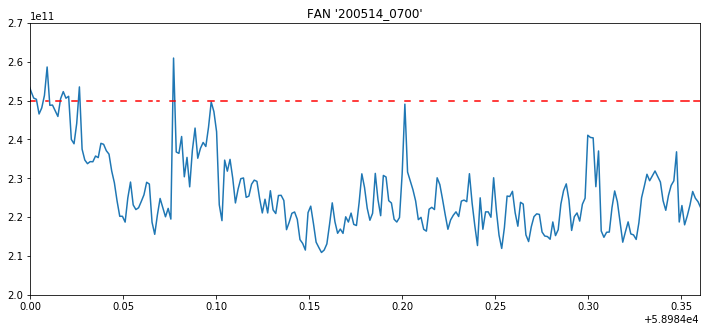

In [105]:
#Make a list of JUST fan state values (0 or 1) and convert from string to int
fan_array = fan_resp.json()
fan_state = [d['fanstate'] for d in fan_array]
fan_state=list(map(int, fan_state))
fan_state = [2.5e11*x for x in fan_state]  #adjust to same order of magitude as the signal

#Create array of fan dates and convert to mjd
fan_date = [d['fsdate'] for d in fan_array]
t = Time(fan_date, format="iso")
fan_date = t.mjd

#Amplitude plot with fan state
plt.figure(figsize=(12, 5))
plt.plot(sig_date, sig)
for i in range(len(fan_state)-1):
    if fan_state[i]==2.5e11:
       plt.plot ([fan_date[i],fan_date[i+1]], [fan_state[i], fan_state[i]],'r-', label='Fan_On')
plt.ylim(2*1e11, 2.7*1e11)  #zoom in on noisy part
plt.xlim(58984, 58984.36)
plt.title('FAN %r' % date)

In [109]:
#find indices for two hour window of noisy signal
#reshaping to larger array
sig_date = d.mjd
sig = np.mean(d[111], 1)

sig = sig [ :len(sig)//2 * 2]
sig = sig.reshape((-1,2)).mean(axis=1)

sig_date = sig_date [ :len(sig_date)//2 * 2]
sig_date = sig_date.reshape((-1,2)).mean(axis=1)

dt = Time(sig_date, format="mjd")

dt.mjd[20600], dt.mjd[24600], dt.iso[20600], dt.iso[24600]

(58983.772493319346,
 58983.86287562837,
 '2020-05-14 18:32:23.423',
 '2020-05-14 20:42:32.454')

In [110]:
#fan state data for specified range of time
fan_array = fan_resp.json()
fan = [d['fanstate'] for d in fan_array]
fan=np.array(list(map(int, fan)))
f=[]
i=0

start=20600
end=24600
mjdstart=dt.mjd[start]
mjdend=dt.mjd[end]

#if fan is on: going from 1 to 0 -> negative slope
#if fan is off: going from 0 to 1 -> positive slope
for i in range(start, end):
    a = np.interp(sig_date[i], fan_date, fan)
    b = np.interp(sig_date[i] + 0.00001, fan_date, fan)
    c = a-b
    if c<=0:
        f.append(0)
    else:
        f.append(1)
    i += 1
f=np.array(f)

Time: '2020-05-14 18:32:23.423' - '2020-05-14 20:42:32.454'


Text(0.5, 1.0, 'Fan on - Fan off')

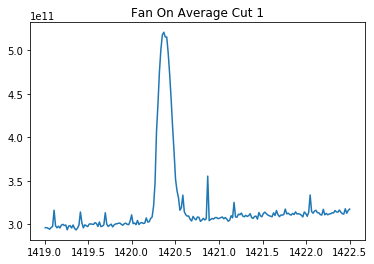

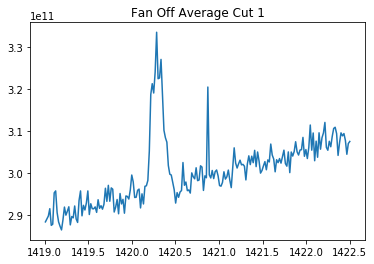

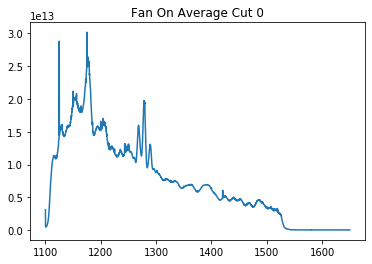

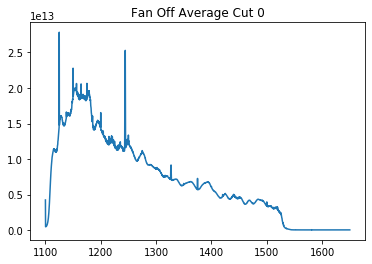

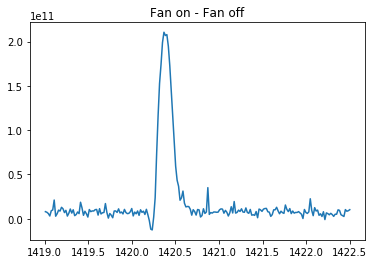

In [111]:
#plot average signal with fan state for specified time range
plt.figure()
plt.plot(d.freq[1], d[111][(d.mjd>mjdstart) & (d.mjd<mjdend)][f,:].mean(axis=0))
plt.title('Fan On Average Cut 1')
plt.figure()
plt.plot(d.freq[1], d[111][(d.mjd>mjdstart) & (d.mjd<mjdend)][~f,:].mean(axis=0))
plt.title('Fan Off Average Cut 1')
plt.figure()
plt.plot(d.freq[0], d[110][(d.mjd>mjdstart) & (d.mjd<mjdend)][f,:].mean(axis=0))
plt.title('Fan On Average Cut 0')
plt.figure()
plt.plot(d.freq[0], d[110][(d.mjd>mjdstart) & (d.mjd<mjdend)][~f,:].mean(axis=0))
plt.title('Fan Off Average Cut 0')
print(color.BOLD + color.RED + "Time: %r - %r" %(dt.iso[start], dt.iso[end]))

#Fan on - Fan off
plt.figure()
x=np.subtract(d[111][(d.mjd>mjdstart) & (d.mjd<mjdend)][f,:].mean(axis=0), d[111][(d.mjd>mjdstart) & (d.mjd<mjdend)][~f,:].mean(axis=0))
plt.plot(d.freq[1], x)
plt.title('Fan on - Fan off')

Signal 1421.3 - 1422.0 MHz
Time: '2020-05-14 18:32:23.423' - '2020-05-14 20:42:32.454'


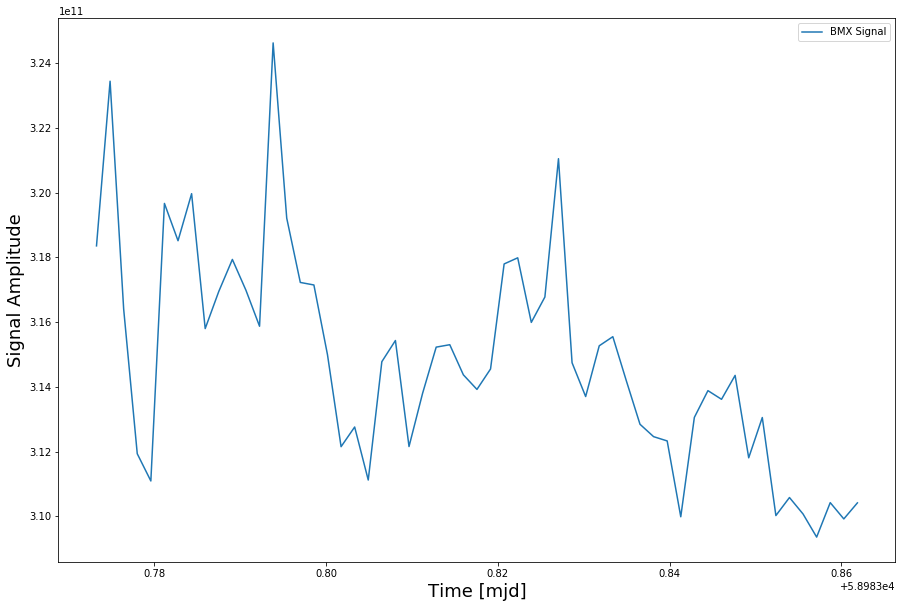

In [112]:
#"clean" signal in between spikes, 1421.3 - 1422.0
#does fan switching on/off correspond with the jumps in the signal? 
small_sig = d[111][:,(d.freq[1]>1421.3) & (d.freq[1]<1422.0)].mean(axis=1)
small_sig = small_sig[(d.mjd>mjdstart) & (d.mjd<mjdend)]
small_sig = small_sig [ :len(small_sig)//140 * 140]
small_sig = small_sig.reshape((-1,140)).mean(axis=1)

small_date = d.mjd
small_date = small_date[(d.mjd>mjdstart) & (d.mjd<mjdend)]
small_date = small_date [ :len(small_date)//140 * 140]
small_date = small_date.reshape((-1,140)).mean(axis=1)

plt.figure(figsize=(15,10))
plt.plot(small_date, small_sig, label='BMX Signal')

for i in range(39,65):
    if fan_state[i]==3.15e11:
       plt.plot ([fan_date[i],fan_date[i+1]], [fan_state[i], fan_state[i]],'r-')
for i in range(66,67):
    if fan_state[i]==3.15e11:
       plt.plot ([fan_date[i],fan_date[i+1]], [fan_state[i], fan_state[i]],'r-', label='Fan On')
    
plt.legend(loc='best')
plt.xlabel('Time [mjd]', fontsize=18)
plt.ylabel('Signal Amplitude', fontsize=18)

print(color.BOLD + 'Signal 1421.3 - 1422.0 MHz')
print(color.BOLD + color.RED + 'Time: %r - %r' %(dt.iso[start], dt.iso[end]))

In [113]:
#Noise analysis for frequencies 1425 - 1500
#comparing two days to see if trends are consistent
date2="200516_0700"
d2 = bmxobs.BMXObs(date2,"all_auto")

Ratio chan1/chan2
Freq: 1425-1500 MHz


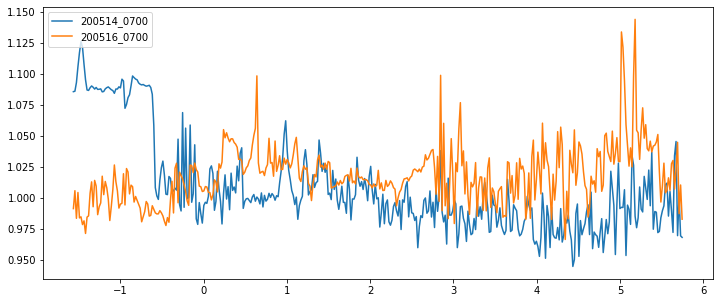

In [114]:
#ratio of channel 1/channel2 for two days
imin=1425
imax=1500

chan1 = d[110][:,imin:imax].mean(axis=1)
chan2 = d[220][:,imin:imax].mean(axis=1)

d2chan1 = d2[110][:,imin:imax].mean(axis=1)
d2chan2 = d2[220][:,imin:imax].mean(axis=1)

rat = chan1/chan2  #day 1
rat2 = d2chan1/d2chan2  #day 2
rat = rat [ :len(rat)//256 * 256]
rat = rat.reshape((-1,256)).mean(axis=1)
rat2 = rat2 [ :len(rat2)//256 * 256]
rat2 = rat2.reshape((-1,256)).mean(axis=1)

ra = d.ra
ra2 = d2.ra
ra = ra[ :len(ra)//256 * 256]
ra = ra.reshape((-1,256)).mean(axis=1)
ra2 = ra2[ :len(ra2)//256 * 256]
ra2 = ra2.reshape((-1,256)).mean(axis=1)

plt.figure(figsize=(12,5))
plt.plot(ra,rat, label=date)
plt.plot(ra2,rat2, label=date2)
plt.legend(loc='upper left')

print(color.BOLD + 'Ratio chan1/chan2')
print(color.BOLD + 'Freq: 1425-1500 MHz')

Channel 1
Day1: '200514_0700'
Day2: '200516_0700'


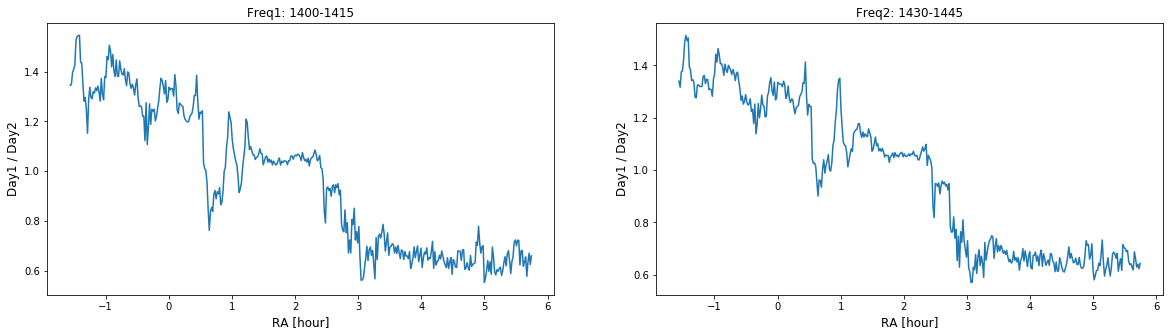

In [115]:
#ratio of day1/day2 for a single channel
#averaged for two different requency ranges
imin1=1400
imax1=1415
imin2=1430
imax2=1445

chan11 = d[110][:,imin1:imax1].mean(axis=1)  # first number is channel, second number is freq range
d2chan11 = d2[110][:,imin1:imax1].mean(axis=1)
chan12 = d[110][:,imin2:imax2].mean(axis=1)
d2chan12 = d2[110][:,imin2:imax2].mean(axis=1)

rat1 = chan11/d2chan11
rat1 = rat1 [ :len(rat1)//256 * 256]
rat1 = rat1.reshape((-1,256)).mean(axis=1)
rat2 = chan12/d2chan12
rat2 = rat2 [ :len(rat2)//256 * 256]
rat2 = rat2.reshape((-1,256)).mean(axis=1)

ra = d.ra
ra = ra[ :len(ra)//256 * 256]
ra = ra.reshape((-1,256)).mean(axis=1)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ra, rat1)
ax1.set_xlabel('RA [hour]', fontsize=12)
ax1.set_ylabel("Day1 / Day2", fontsize=12)
ax1.set_title("Freq1: 1400-1415", fontsize=12)

ax2.plot(ra, rat2)
ax2.set_xlabel('RA [hour]', fontsize=12)
ax2.set_ylabel("Day1 / Day2", fontsize=12)
ax2.set_title("Freq2: 1430-1445", fontsize=12)

print(color.BOLD + 'Channel 1')
print(color.BOLD + 'Day1: %r' % date)
print(color.BOLD + 'Day2: %r' % date2)

Channel 1
Freq1: 1400-1415
Freq2: 1430-1445


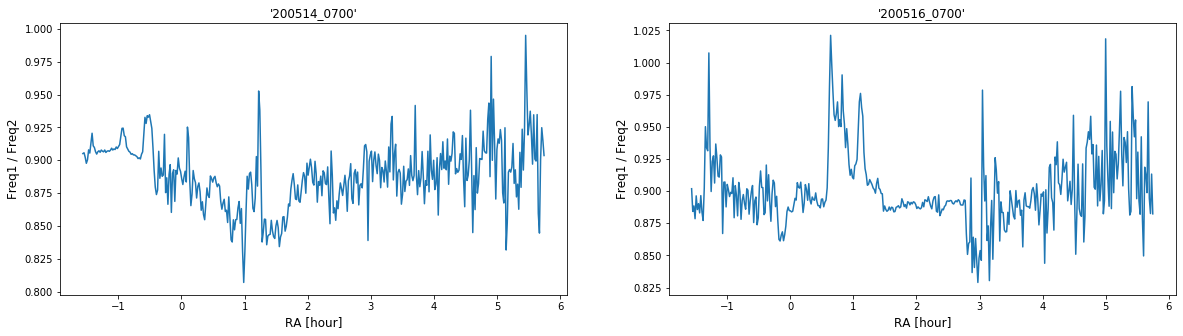

In [116]:
#ratio of channel averaged over freq1 versus channel averaged over freq2
#want to see if gains are coherent between frequencies
#do for 2 days
imin1=1400
imax1=1415
imin2=1430
imax2=1445

chan11 = d[110][:,imin1:imax1].mean(axis=1)  #first number is channel, second number is frequency range
chan12 = d[110][:,imin2:imax2].mean(axis=1)
d2chan11 = d2[110][:,imin1:imax1].mean(axis=1)  #day 2
d2chan12 = d2[110][:,imin2:imax2].mean(axis=1)

rat = chan11/chan12
rat = rat [ :len(rat)//256 * 256]
rat = rat.reshape((-1,256)).mean(axis=1)
d2rat = d2chan11/d2chan12
d2rat = d2rat [ :len(d2rat)//256 * 256]
d2rat = d2rat.reshape((-1,256)).mean(axis=1)

ra = d.ra
ra = ra[ :len(ra)//256 * 256]
ra = ra.reshape((-1,256)).mean(axis=1)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ra, rat)
ax1.set_xlabel('RA [hour]', fontsize=12)
ax1.set_ylabel('Freq1 / Freq2', fontsize=12)
ax1.set_title("%r" % date, fontsize=12)

ax2.plot(ra, d2rat)
ax2.set_xlabel('RA [hour]', fontsize=12)
ax2.set_ylabel('Freq1 / Freq2', fontsize=12)
ax2.set_title("%r" % date2, fontsize=12)

print(color.BOLD + "Channel 1")
print(color.BOLD + "Freq1: 1400-1415")
print(color.BOLD + "Freq2: 1430-1445")